In [90]:
from collections import deque
from enum import Enum
import itertools as it
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
with open('../input.txt') as fp:
    lines = [line.rstrip('\n') for line in fp]

In [33]:
def parse_input(lines):
    array = np.array([list(line) for line in lines])
    locations = np.where(array == 'S')
    locations = [(locations[0].item(), locations[1].item())]
    locations = set(locations)
    array[array == 'S'] = '.'  # Replace start with garden tile
    return array, locations


map, locations = parse_input(lines)
center_loc = InfectionLocation.CENTER.resolve(*map.shape)
assert np.all(map[center_loc[0], :] == '.')
assert np.all(map[:, center_loc[1]] == '.')
assert np.all(map[0, :] == '.')
assert np.all(map[-1, :] == '.')
assert np.all(map[:, 0] == '.')
assert np.all(map[:, -1] == '.')

In [39]:
map.shape

(131, 131)

In [9]:
def step(input_array: np.ndarray, locations: set[tuple[int, int]]) -> set[tuple[int, int]]:
    """Perform one step of the simulation.
    
    Args:
        input_array: The 2d input array (<U1 dtype).
        locations_array: The set of possible locations.
        
    Returns:
        The new set of possible locations."""
    height, width = input_array.shape
    new_locations = set()
    for location in locations:
        i, j = location
        # Check up
        if i > 0 and input_array[i - 1, j] == '.':
            new_locations.add((i - 1, j))
        # Check right
        if j < width - 1 and input_array[i, j + 1] == '.':
            new_locations.add((i, j + 1))
        # Check down
        if i < height - 1 and input_array[i + 1, j] == '.':
            new_locations.add((i + 1, j))
        # Check left
        if j > 0 and input_array[i, j - 1] == '.':
            new_locations.add((i, j - 1))
    return new_locations


def simulate_cell(map: np.ndarray, locations: set[tuple[int, int]], nsteps: int) -> set[tuple[int, int]]:
    for _ in range(nsteps):
        locations = step(map, locations)
    return locations


def simulate_until_periodic(map: np.ndarray, locations: set[tuple[int, int]], period=2, maxsteps=1_000) -> tuple[Sequence[int], Sequence[set[tuple[int, int]]]]:
    buffer = deque(maxlen=period)
    sizes = [len(locations)]
    # Fill buffer up to period length
    buffer.append(locations)
    for _ in range(period - 1):
        locations = step(map, locations)
        buffer.append(locations)
        sizes.append(len(locations))
    
    for _ in range(maxsteps):
        locations = step(map, locations)
        if locations == buffer[0]:
            break
        buffer.append(locations)
        sizes.append(len(locations))
    else:
        raise RuntimeError(f'Did not find periodicity within maxsteps={maxsteps} steps.')
    return sizes, buffer


infection_trajectory, period = simulate_until_periodic(map, locations)
print(len(infection_trajectory))

131


In [19]:
def time_until_start_of_infection(y: int, x: int, map_height: int, map_width: int) -> int:
    """Return the number of steps until the cell (y, x) is infected for the first time.
    
    Args:
        y: The vertical coordinate of the cell relative to the starting cell (0=starting, -1=upper neighbor, etc.).
        x: The horizontal coordinate of the cell relative to the starting cell (0=starting, -1=left neighbor, etc.).
        map_height: The height of the map (odd).
        map_width: The width of the map (odd).
        
    Returns:
        The number of steps.
    """
    return _tis_x(x, map_width) + _tis_y(y, map_height)


def _tis_x(x: int, map_width: int) -> int:
    h0 = map_width // 2
    if x == 0:
        return 0
    else:
        return h0 + 1 + (np.abs(x) - 1) * map_width

def _tis_y(y: int, map_height: int) -> int:
    w0 = map_height // 2
    if y == 0:
        return 0
    else:
        return w0 + 1 + (np.abs(y) - 1) * map_height

In [15]:
class InfectionLocation(Enum):
    """The starting location of the infection."""
    CENTER = 0
    TOP = 1
    TOP_RIGHT = 2
    RIGHT = 3
    BOTTOM_RIGHT = 4
    BOTTOM = 5
    BOTTOM_LEFT = 6
    LEFT = 7
    TOP_LEFT = 8

    def resolve(self, map_height, map_width) -> tuple[int, int]:
        """Return the absolute coordinate of the infection location within the map.
        
        Args:
            map_height: The height of the map (odd).
            map_width: The width of the map (odd).
            
        Returns:
            The absolute coordinate (i, j).
        """
        if self == InfectionLocation.CENTER:
            return (map_height // 2, map_width // 2)
        elif self == InfectionLocation.TOP:
            return (0, map_width // 2)
        elif self == InfectionLocation.TOP_RIGHT:
            return (0, map_width - 1)
        elif self == InfectionLocation.RIGHT:
            return (map_height // 2, map_width - 1)
        elif self == InfectionLocation.BOTTOM_RIGHT:
            return (map_height - 1, map_width - 1)
        elif self == InfectionLocation.BOTTOM:
            return (map_height - 1, map_width // 2)
        elif self == InfectionLocation.BOTTOM_LEFT:
            return (map_height - 1, 0)
        elif self == InfectionLocation.LEFT:
            return (map_height // 2, 0)
        elif self == InfectionLocation.TOP_LEFT:
            return (0, 0)
        else:
            raise ValueError(f'Invalid infection location: {self}')
    
    
def infection_location(y: int, x: int) -> InfectionLocation:
    if x == 0:
        if y > 0:
            return InfectionLocation.TOP
        elif y < 0:
            return InfectionLocation.BOTTOM
        else:
            return InfectionLocation.CENTER
    elif x > 0:
        if y > 0:
            return InfectionLocation.TOP_LEFT
        elif y < 0:
            return InfectionLocation.BOTTOM_LEFT
        else:
            return InfectionLocation.LEFT
    else:
        if y > 0:
            return InfectionLocation.TOP_RIGHT
        elif y < 0:
            return InfectionLocation.BOTTOM_RIGHT
        else:
            return InfectionLocation.RIGHT


infection_trajectories = {loc: simulate_until_periodic(map, set([loc.resolve(*map.shape)]))[0] for loc in InfectionLocation}
time_until_fully_infected = {loc: len(infection_trajectories[loc]) - 2 for loc in InfectionLocation}

In [16]:
time_until_fully_infected

{<InfectionLocation.CENTER: 0>: 129,
 <InfectionLocation.TOP: 1>: 194,
 <InfectionLocation.TOP_RIGHT: 2>: 259,
 <InfectionLocation.RIGHT: 3>: 194,
 <InfectionLocation.BOTTOM_RIGHT: 4>: 259,
 <InfectionLocation.BOTTOM: 5>: 194,
 <InfectionLocation.BOTTOM_LEFT: 6>: 259,
 <InfectionLocation.LEFT: 7>: 194,
 <InfectionLocation.TOP_LEFT: 8>: 259}

In [17]:
def infections_in_cell(y: int, x: int, t: int, map: np.ndarray) -> int:
    """Return the number of infections in cell (y, x) at time t.
    
    Args:
        y: The vertical coordinate of the cell relative to the starting cell (0=starting, -1=upper neighbor, etc.).
        x: The horizontal coordinate of the cell relative to the starting cell (0=starting, -1=left neighbor, etc.).
        t: The number of steps taken.
        map: The 2d map array.
        
    Returns:
        The number of infections.
    """
    tis = time_until_start_of_infection(y, x, *map.shape)
    infection_location_ = infection_location(y, x)
    tif = time_until_fully_infected[infection_location_]
    if t < tis:
        return 0
    elif t < tis + tif:
        return infection_trajectories[infection_location_][t - tis]
    else:
        t_since_end_of_infection = t - tis - tif
        phase = t_since_end_of_infection % 2
        return infection_trajectories[infection_location_][-2 + phase]

In [82]:
_ic = [infections_in_cell(0, 0, t, map) for t in (0, 1, 2, 128, 129, 130, 131)]
print(_ic)

_ic = [infections_in_cell(1, 0, t, map) for t in (65, 66, 67, 259, 260, 261, 262)]
print(_ic)

_ic = [infections_in_cell(-1, -2, t, map) for t in (262, 263, 264, 263 + 259 - 1, 263 + 259, 263 + 259 + 1, 263 + 259 + 2)]
print(_ic)

[1, 4, 9, 7330, 7250, 7334, 7250]
[0, 1, 3, 7332, 7250, 7334, 7250]
[0, 1, 2, 7333, 7250, 7334, 7250]


In [106]:
def total_infections_slow(T: int, map: np.ndarray, progress_bar=True) -> int:
    """Return the total number of infections after T steps.
    
    Args:
        T: The number of steps.
        map: The 2d map array.
        
    Returns:
        The number of infections.
    """
    H, W = map.shape
    h_mod = H // 2 + 1
    w_mod = W // 2 + 1
    y_max = (T - h_mod) // H + 1
    x_max = (T - w_mod) // W + 1
    total = 0
    iterable_ = cell_coordinates = it.product(range(-y_max, y_max + 1), range(-x_max, x_max + 1))
    if progress_bar:
        iterable_ = tqdm.tqdm(cell_coordinates, total=(2 * y_max + 1) * (2 * x_max + 1))
    for y, x in iterable_:
        total += infections_in_cell(y, x, T, map)
    return total

In [108]:
_infectionss_slow = [total_infections_slow(t, map, progress_bar=False) for t in range(1, 5001)]

In [115]:
def count_fully_infected(T: int, y: int, map: np.ndarray) -> int:
    """Return the number of fully infected cells in row y after T steps.
    
    Args:
        T: The number of steps.
        y: The vertical coordinate of the cell relative to the starting cell (0=starting, -1=upper neighbor, etc.).
        map: The 2d map array.
        
    Returns:
        The number of fully infected cells.
    """
    H, W = map.shape
    w_mod = H // 2 + 1
    tis_y = _tis_y(y, H)
    if y != 0:
        tif_zero = time_until_fully_infected[InfectionLocation.TOP]
        tif_nonzero = time_until_fully_infected[InfectionLocation.TOP_RIGHT]
    else:
        tif_zero = time_until_fully_infected[InfectionLocation.CENTER]
        tif_nonzero = time_until_fully_infected[InfectionLocation.RIGHT]
    if T < tis_y + tif_zero:
        return 0
    elif T < tis_y + w_mod + tif_nonzero:
        return 1
    else:
        largest_x = (T - tis_y - tif_nonzero - w_mod) // W + 1
        return 2 * largest_x + 1


def total_partially_infected(T: int, y: int, num_fully_infected: int, map: np.ndarray) -> int:
    """Return the total number of infections in partially infected cells in row y after T steps.
    
    Args:
        T: The number of steps.
        y: The vertical coordinate of the cell relative to the starting cell (0=starting, -1=upper neighbor, etc.).
        num_fully_infected: The number of fully infected cells in row
        map: The 2d map array.

    Returns:
        The number of partially infected cells.
    """
    H, W = map.shape
    w_mod = H // 2 + 1
    tis_y = _tis_y(y, H)
    if T < tis_y:
        return 0
    elif T < tis_y + w_mod:
        largest_x = 0
    else:
        largest_x = (T - tis_y - w_mod) // W + 1

    if num_fully_infected == 0:
        lowest_x = 0
    else:
        lowest_x = (num_fully_infected - 1) // 2 + 1
    partial_totals = 0
    for x in range(lowest_x, largest_x + 1):
        if x == 0:
            partial_totals += infections_in_cell(y, x, T, map)
        else:
            partial_totals += infections_in_cell(y, x, T, map)
            partial_totals += infections_in_cell(y, -x, T, map)
    return partial_totals


def total_infections(T: int, map: np.ndarray, progress_bar=True) -> int:
    """Return the total number of infections after T steps.
    
    Args:
        T: The number of steps.
        map: The 2d map array.
        
    Returns:
        The number of infections.
    """
    H, W = map.shape
    h_mod = H // 2 + 1
    y_max = (T - h_mod) // H + 1
    ys = np.arange(-y_max, y_max + 1)
    total = 0
    iterator_ = tqdm.tqdm(ys) if progress_bar else ys
    for y in iterator_:
        total_01 = [infections_in_cell(y, 0, T, map), infections_in_cell(y, 1, T, map)]
        num_fully_infected = count_fully_infected(T, y, map)
        if num_fully_infected == 0:
            num_even, num_odd = 0, 0
        else:
            num_positive = (num_fully_infected - 1) // 2
            num_positive_odd = (num_positive + 1) // 2
            num_odd = 2 * num_positive_odd
            num_even = num_fully_infected - num_odd
        total_fully_infected = total_01[0] * num_even + total_01[1] * num_odd
        total += total_fully_infected + total_partially_infected(T, y, num_fully_infected, map)
    return total

In [89]:
print([count_fully_infected(T=t, y=0, map=map) for t in (0, 128, 129, 130, 259, 260, 261)])
_y = -10
_n_moves = np.abs(_y) - 1
print([count_fully_infected(T=t, y=-10, map=map) for t in (66 + _n_moves * 131 + 194 - 1,
                                                           66 + _n_moves * 131 + 194,
                                                           66 + _n_moves * 131 + 194 + 1,
                                                           66 + _n_moves * 131 + 66 + 259 - 1,
                                                           66 + _n_moves * 131 + 66 + 259,
                                                           66 + _n_moves * 131 + 66 + 259 + 1,)])

[0, 0, 1, 1, 1, 3, 3]
[0, 1, 1, 1, 3, 3]


In [116]:
print([total_partially_infected(T=t, y=0, num_fully_infected=0, map=map) for t in (0, 1, 64, 65, 66, 67, 128)])
print([total_partially_infected(T=t, y=0, num_fully_infected=1, map=map) for t in (129, 130, 66 + 194 - 2, 66 + 194 - 1)])
print([total_partially_infected(T=t, y=0, num_fully_infected=3, map=map) for t in (66 + 194,)])

[1, 4, 3617, 3703, 3879, 3965, 10665]
[3557, 3561, 17819, 17999]
[3557]


In [102]:
total_infections(1, map)

100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


4

In [122]:
T_actual = 26501365
total_infections(T_actual, map)

100%|██████████| 404601/404601 [00:05<00:00, 74711.39it/s]


596857397104703

In [95]:
old_infectionss = np.loadtxt('n_locations.txt')

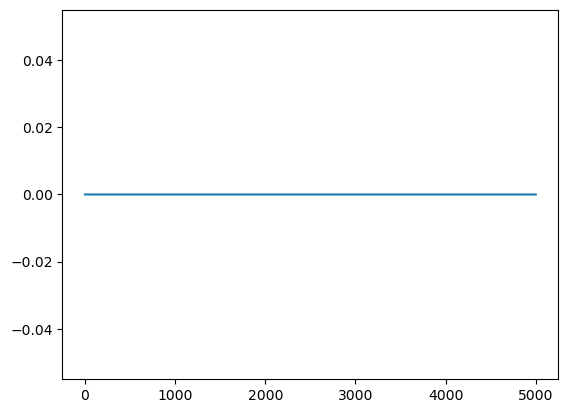

In [119]:
_infectionss = [total_infections(t, map, progress_bar=False) for t in range(1, 5001)]
plt.plot(old_infectionss - _infectionss)

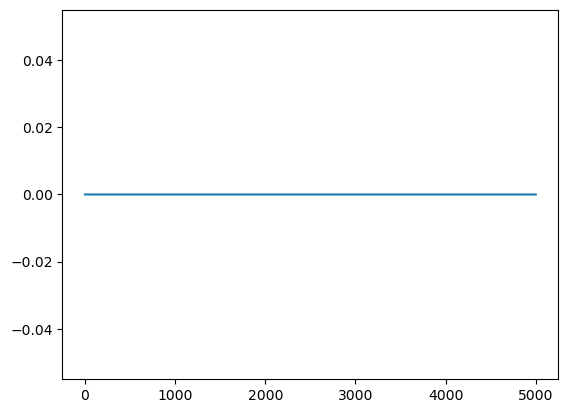

In [120]:
plt.plot(np.array(_infectionss_slow) - _infectionss)

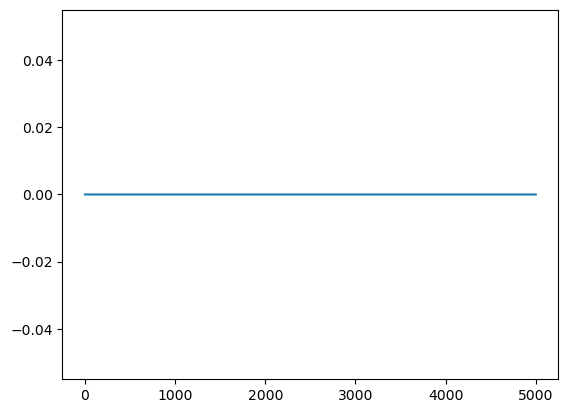

In [121]:
plt.plot(old_infectionss - _infectionss_slow)